# **Using ML to Recommend Songs on Spotify**

This project is entirely for personal use and for fun. I am in no way profiting off of this or using anything in this or any associated notebook/script/file for any other purpose than to listen to good music.

With that out of the way, the motivation for this project lies in the fact that, lately, I just haven't really been enjoying listening to my discover weekly. Of course, I'm sure that the models over at Spotify are much more sophisticated than what I'm writing here, but I told myself that "even I could do better than this!" so I figured that it might be worth the effort to try! I have already (painstakingly) collected the necessary data, and as we'll see, I'm actually shaving most of it off for the sake of simplicity lol. The goal here is primarily to practice my ML skills on a real problem (that I had) and as a nice little byproduct also get a bunch of songs to listen to.

To get started, let's first read in and get familiar with the data!

In [1]:
import pandas as pd

artists = pd.read_pickle("./data/top_artists.pkl")
tracks = pd.read_pickle("./data/top_tracks.pkl")
playlists = pd.read_pickle("./data/playlists.pkl")
recs = pd.read_pickle("./data/recommendations.pkl")

In [2]:
print(f"Shape of artists: {artists.shape}")
print(f"Shape of tracks: {tracks.shape}")
print(f"Shape of playlists: {playlists.shape}")
print(f"Shape of recommendations: {recs.shape}")

Shape of artists: (60, 6)
Shape of tracks: (60, 36)
Shape of playlists: (1146, 41)
Shape of recommendations: (16522, 35)


# Tidying the data

Since `playlists` has certain columns that aren't really useful (`added_at`, etc) and aren't in `recs` and vice versa, I'm just manually dropping those columns. Doing the same for `tracks` since that is really just an extension of `playlists`.

In [3]:
# Find columns in 'tracks' that are not in 'recs'
drop_cols = playlists.columns.difference(recs.columns)

# Drop these columns from 'tracks'
playlists = playlists.drop(columns = drop_cols)

# Find columns in 'tracks' that are not in 'recs'
drop_cols = tracks.columns.difference(recs.columns)
tracks = tracks.drop(columns = drop_cols)

# Visual aid
print(f"Shape of playlists after dropping: {playlists.shape}")
print(f"Shape of recommendations: {recs.shape}")
print(f"Shape of tracks after dropping: {tracks.shape}")
print(f"{playlists.columns == recs.columns}")
print(f"{tracks.columns == recs.columns}")

Shape of playlists after dropping: (1146, 35)
Shape of recommendations: (16522, 35)
Shape of tracks after dropping: (60, 35)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


Next, let's remove any duplicate tracks within any of the data frames

In [4]:
tracks = tracks.drop_duplicates(subset = "id", keep = "last")
tracks = tracks.reset_index()

playlists = playlists.drop_duplicates(subset = "id", keep = "last")
playlists = playlists.reset_index()

recs = recs.drop_duplicates(subset = "id", keep = "last")
recs = recs.reset_index()

print(f"Shape of tracks after dropping duplicates: {tracks.shape}")
print(f"Shape of playlists after dropping duplicates: {playlists.shape}")
print(f"Shape of recs after dropping duplicates: {recs.shape}")

Shape of tracks after dropping duplicates: (60, 36)
Shape of playlists after dropping duplicates: (1023, 36)
Shape of recs after dropping duplicates: (16522, 36)


I noticed that some recommendations are duplicates of songs I already have in my playlists or top tracks, so let's remove those.

In [5]:
recs = recs[-recs["id"].isin([playlists["id"], tracks["id"]])]
print(f"Shape of recs after dropping duplicates: {recs.shape}")

Shape of recs after dropping duplicates: (16522, 36)


There seems to be a few columns in every data frame that just isn't important (i.e. `uri`). So I'll just drop those too.

Note: I ended up dropping the `genres` and `album_genres` columns because of the fact that there are just so many different genres that 1) the size of the data would explode trying to encode them using something like one-hot encoding and 2) differently-sized data frames (e.g. `filtered_playlists` and `filtered_tracks` in the cell below) just have different unique genres. For example, `filtered_track` only contains ~60 columns after exploding the `genres` column, but `filtered_playlists` ends up containing several hundred columns since there are just more songs and thus more genres in it (and that's not even including `album_genres`!). My initial thought was to perform a sort of 'inner join' on the genres to only get the ones that are in all three data frames, but I figured that approach would be a little logically inconsistent, since I'd just arbitrarily be weighing the genres of songs in my top tracks and not any other genres. Indeed, I think that exploding the `genres` and `album_genres` columns would then make my models more prone to overfitting *and* less robust to new songs (which would likely have new genres), so I'm just getting rid of this outright.

However, I do agree that the genres that describe a song/album are crucial to how I would rate them, so future work should find a way to include these as features.

In [6]:
filtered_tracks = tracks.drop(columns=[
    "index", "name", "type", "is_local", "disc_number", "track_number",
    "genres", "artist_id", "artist_name", "album_genres", "album_artist_id",
    "album_artist_name", "album_id", "album_name", "album_release_date",
    "album_tracks", "album_type", "uri", "track_href",
    "analysis_url", "time_signature", "key", "mode"
])

filtered_playlists = playlists.drop(columns=[
    "index", "name", "type", "is_local", "disc_number", "track_number",
    "genres", "artist_id", "artist_name", "album_genres", "album_artist_id",
    "album_artist_name", "album_id", "album_name", "album_release_date",
    "album_tracks", "album_type", "uri", "track_href",
    "analysis_url", "time_signature", "key", "mode"
])

filtered_recs = recs.drop(columns=[
    "index", "name", "type", "is_local", "disc_number", "track_number",
    "genres", "artist_id", "artist_name", "album_genres", "album_artist_id",
    "album_artist_name", "album_id", "album_name", "album_release_date",
    "album_tracks", "album_type", "uri", "track_href",
    "analysis_url", "time_signature", "key", "mode"
])

print(f"Shape of tracks after dropping columns: {filtered_tracks.shape}")
print(f"Shape of playlists after dropping columns: {filtered_playlists.shape}")
print(f"Shape of recommendations after dropping columns: {filtered_recs.shape}")

Shape of tracks after dropping columns: (60, 13)
Shape of playlists after dropping columns: (1023, 13)
Shape of recommendations after dropping columns: (16522, 13)


Next, I'm going to be one-hot encoding the `explicit`column

In [7]:
filtered_tracks["explicit"] = filtered_tracks["explicit"].astype(int)
filtered_playlists["explicit"] = filtered_playlists["explicit"].astype(int)
filtered_recs["explicit"] = filtered_recs["explicit"].astype(int)

For the training stage, the `id` column isn't necessary, so I'll just drop it for now

In [8]:
filtered_tracks = filtered_tracks.drop(columns = ["id"])
filtered_playlists = filtered_playlists.drop(columns = ["id"])
filtered_recs = filtered_recs.drop(columns = ["id"])

Finally, I'm going to standardize everything in each dataframe. Using `playlists` as the basis for scaling seems to work fine, since it's going to be used in the training stage of the final model and contains significantly more data than `tracks`.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(filtered_playlists)

scaled_playlists = pd.DataFrame(scaler.transform(filtered_playlists), columns=filtered_playlists.columns)
scaled_recs = pd.DataFrame(scaler.transform(filtered_recs), columns=filtered_recs.columns)
scaled_tracks = pd.DataFrame(scaler.transform(filtered_tracks), columns=filtered_tracks.columns)

# Revert categorical features back to binary 0-1
scaled_playlists["explicit"] = scaled_playlists["explicit"].apply(lambda x: 1 if x > 0 else 0)
scaled_recs["explicit"] = scaled_recs["explicit"].apply(lambda x: 1 if x > 0 else 0)
scaled_tracks["explicit"] = scaled_tracks["explicit"].apply(lambda x: 1 if x > 0 else 0)

# Creating a ratings system

Because tracks are ambiguous by themselves, I am going to rate them by training a separate model on my top tracks / top artists data and then using its predictions to rate my playlists. I've manually rated the tracks in `tracks` already to turn this into a supervised problem. Everything is rated on a scale from 1-10.

In [10]:
import numpy as np

ratings = np.array([
    10, 10, 10, 7, 4, 0, 10, 7, 8, 4,
    8, 6, 7, 8, 9, 10, 5, 9, 3, 6,
    7, 5, 4, 9, 6, 7, 6, 8, 8, 9,
    4, 6, 8, 8, 7, 4, 4, 4, 6, 7,
    4, 4, 5, 3, 6, 9, 6, 7, 7, 4,
    3, 5, 7, 4, 6, 9, 3, 7, 6, 5
])

scaled_tracks["rating"] = ratings
scaled_tracks.head()

,popularity,explicit,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,rating
0,1.339225,1,0.331624,-0.645776,0.469787,0.337678,-0.528525,0.810261,-0.462745,-0.451594,-0.529533,0.090280,10
1,0.953994,0,0.432226,1.014975,0.118916,0.337678,-0.693046,-0.640427,0.893996,-0.506251,2.011381,-0.373839,10
2,1.820764,0,-0.899876,-0.362233,-0.994513,-1.206020,-0.688159,1.467462,0.019249,-0.212466,-1.216617,-0.077995,10
3,1.098455,1,1.424430,-0.761507,1.120067,0.924002,-0.362374,-1.108342,-0.462755,-0.212466,-0.849308,-1.197008,7
4,-2.272319,1,-0.080746,1.067054,0.619492,0.414395,-0.490245,-0.989924,-0.462755,-0.728299,1.587896,-0.472597,4


### Linear Regression
First, I'm going to try fitting a linear regression model to establish a baseline level of performance. Note that there isn't a ton
of data to work with.

In [11]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X, y = scaled_tracks.drop(columns = ["rating"]), scaled_tracks["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [12]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print(f"Model parameters: {lin_reg.coef_}")
print(f"Model bias: {lin_reg.intercept_}")
print()

from sklearn.metrics import mean_squared_error

# Predict and evalute
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

rmse_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"RMSE from training: {rmse_train}")
print(f"RMSE from testing: {rmse_test}")

Model parameters: [ 0.9228762  -1.07834656  0.85275065 -0.90363133 -0.19647598  0.09855639
 -0.53000903 -0.11179907 -0.33650507  0.25496525  0.01031902 -0.00177784]
Model bias: 7.415017019639044

RMSE from training: 1.382948855546236
RMSE from testing: 1.7500593980748675


### XGBoost

Next, I'm going to try a tree-based model. Since this is a regression problem, I think XGBoost would work well. Bagging might also be something good to look into for future reference!

In [13]:
import xgboost as xgb

# Define the parameter grid for hyperparameter tuningO
# Note: I ran this a few times manually to tune the hyperparameter grid
# So that any single run didn't take too long.
param_grid = {
    "max_depth": [4, 5, 6],
    "learning_rate": [0.125, 0.15, 0.175],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "n_estimators": [175, 200, 225],
    "reg_alpha": [0.3, 0.5, 0.7],  # L1 regularization term (alpha)
    "reg_lambda": [1.5, 1.55, 1.6]    # L2 regularization term (lambda)
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective = "reg:squarederror", tree_method = "hist")

from sklearn.model_selection import GridSearchCV

gcv = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose = 1
)

# Fit the model
gcv.fit(X_train, y_train)

# Best parameters and RMSE
best_params = gcv.best_params_
best_rmse = -gcv.best_score_

# Train  model with the best parameters
xgb_model_best = xgb.XGBRegressor(**best_params, objective = "reg:squarederror", tree_method = "hist")
xgb_model_best.fit(X_train, y_train)

# Predict and evaluate
y_pred_train = xgb_model_best.predict(X_train)
y_pred_test = xgb_model_best.predict(X_test)

from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")
print(f"RMSE from training: {rmse_train}")
print(f"RMSE from testing: {rmse_test}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.175, 'max_depth': 5, 'n_estimators': 225, 'reg_alpha': 0.5, 'reg_lambda': 1.55, 'subsample': 0.8}
Best RMSE: 1.924688378727901
RMSE from training: 0.07606720379521913
RMSE from testing: 1.9897453092764175


### Neural Network

It seems like the XGBoost model performed generally better than the linear regression model. Even though both models had similar testing accuracy, the XGBoost model had a much lower training accuracy, implying that it wasn't underfitting the data. Next, I'll try developing a neural network model to kind of *redo* a typical regression approach now with added nonlinearity

In [14]:
# Build a neural network model using pytorch to predict ratings
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network architecture
class NeuralNetwork(nn.Module):

    # Define initialization
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64) # Number of features of training data
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)

    # Define forward prop
    # Architecture: f_1(X) -> relu -> f_2(X) -> relu -> f_3(x) -> y_hat
    def forward(self, X):
        X = F.relu(self.layer1(X))
        X = F.relu(self.layer2(X))
        X = self.layer3(X)
        return X

Just reformatting the data really quick...

In [15]:
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32)

Ok now!

In [16]:
# Lists to keep track of losses
train_losses = []
test_losses = []

nn_model = NeuralNetwork()
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(nn_model.parameters(), lr = 0.001)
epochs = 150

# Training the model
for epoch in range(epochs):

    nn_model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
        # Forward pass
        outputs = nn_model(inputs)
        loss = loss_fn(outputs, targets.view(-1, 1))

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Testing loop
    nn_model.eval()
    total_test_loss = 0
    with torch.no_grad():

        for inputs, targets in test_loader:

            outputs = nn_model(inputs)
            loss = torch.sqrt(loss_fn(outputs, targets.view(-1, 1)))
            total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

    if (epoch + 1) % 10 == 0:
        progress_bar = "|" * ((epoch + 1) // 10) + "_" * (epochs // 10 - (epoch + 1) // 10)
        print(f"{progress_bar} Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

|______________ Epoch [10/150], Train Loss: 35.1458, Test Loss: 5.5480
||_____________ Epoch [20/150], Train Loss: 17.9925, Test Loss: 3.8005
|||____________ Epoch [30/150], Train Loss: 6.6741, Test Loss: 2.7139
||||___________ Epoch [40/150], Train Loss: 3.8696, Test Loss: 2.4015
|||||__________ Epoch [50/150], Train Loss: 3.0436, Test Loss: 2.2447
||||||_________ Epoch [60/150], Train Loss: 2.5370, Test Loss: 2.2125
|||||||________ Epoch [70/150], Train Loss: 1.6615, Test Loss: 2.1744
||||||||_______ Epoch [80/150], Train Loss: 1.4926, Test Loss: 2.1993
|||||||||______ Epoch [90/150], Train Loss: 1.3027, Test Loss: 2.2005
||||||||||_____ Epoch [100/150], Train Loss: 1.4642, Test Loss: 2.1430
|||||||||||____ Epoch [110/150], Train Loss: 1.3477, Test Loss: 2.1989
||||||||||||___ Epoch [120/150], Train Loss: 1.1951, Test Loss: 2.2129
|||||||||||||__ Epoch [130/150], Train Loss: 0.9496, Test Loss: 2.2211
||||||||||||||_ Epoch [140/150], Train Loss: 0.8810, Test Loss: 2.2569
|||||||||||||

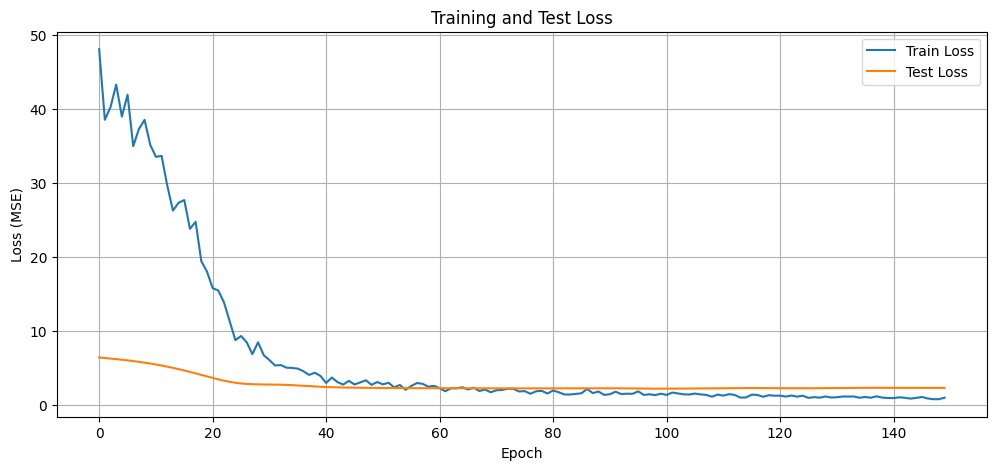

In [17]:
import matplotlib.pyplot as plt

# Plot training and test loss side by side
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

Looks like ~80 epochs works the best, so I'll use that model

In [18]:
best_nn_model = NeuralNetwork()
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(best_nn_model.parameters(), lr = 0.001)
epochs = 80

# Training loop
for epoch in range(epochs):

    best_nn_model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:

        # Forward pass
        outputs = best_nn_model(inputs)
        loss = loss_fn(outputs, targets.view(-1, 1))

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Testing loop
    best_nn_model.eval()
    total_test_loss = 0
    with torch.no_grad():

        for inputs, targets in test_loader:

            outputs = best_nn_model(inputs)
            loss = torch.sqrt(loss_fn(outputs, targets.view(-1, 1)))
            total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)

    if (epoch + 1) % 10 == 0:
        progress_bar = "|" * ((epoch + 1) // 10) + "_" * (epochs // 10 - (epoch + 1) // 10)
        print(f'{progress_bar} Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

|_______ Epoch [10/80], Train Loss: 37.4187, Test Loss: 5.8715
||______ Epoch [20/80], Train Loss: 22.1809, Test Loss: 4.2411
|||_____ Epoch [30/80], Train Loss: 8.0010, Test Loss: 2.9496
||||____ Epoch [40/80], Train Loss: 4.1053, Test Loss: 2.6277
|||||___ Epoch [50/80], Train Loss: 2.6571, Test Loss: 2.3187
||||||__ Epoch [60/80], Train Loss: 2.7170, Test Loss: 2.2094
|||||||_ Epoch [70/80], Train Loss: 1.9410, Test Loss: 2.1553
|||||||| Epoch [80/80], Train Loss: 1.9837, Test Loss: 2.1239


Looks like, overall, the neural network  model performed the best in terms of avoiding both over and underfitting, so I'll just be running with that going forward. I also fit these models a few times manually, since the runtime wasn't *too* long, and I think that either the neural network model or the xgboost model would be a fine pick. The former, however, seems to be a little less robust (though it is relatively consistent  at being noticeably more accurate than the xgboost model it seems).

Notably, I just rated everything 1-10, so the data is technically discrete, and therefore would suit a classification problem better. However, I think that since the rating is 1-10, I would prefer a regression approach where the model could rate things something like a 7.5, for example. Future work on this might somehow make this process more smooth by taking 1 of 2 approaches: either turn the problem into a softmax/softprob classification one with 10 categories or turn it into a regression problem by adding some sort of continuity to the data. The latter might be done by adding some sort of small noise to the ratings or taking a more refined approach of rating the top tracks.

On the other hand, this entire process could also just be done in an unsupervised setting using something like a collaborative/content based filtering model or a hybrid.

Also note that, since I haven't set bounds on what each model can predict, the range of any given model is technically $(-\infty, \infty)$, so I'll reduce that to $[0, 10]$ when making the final predictions. However, I don't think that that's necessary here since I just want to get a gauge of how each model is performing.

Just for fun, let's take a look at what each model rated a few of the songs in my top tracks vs what I had rated them!

In [19]:
# View test predictions for all three models
best_nn_model.eval()
with torch.no_grad():

    y_pred_nn = best_nn_model(X_test_tensor).numpy().flatten()

y_pred_lin = lin_reg.predict(X_test)
y_pred_xgb = xgb_model_best.predict(X_test)

# Use `tracks` dataframe to get the track names that correspond to the test set
test_tracks = tracks.iloc[y_test.index]

# Create a dataframe with the predictions from each model
preds_df = pd.DataFrame({
    "track_name": test_tracks["name"],
    "artist_name": test_tracks["artist_name"],
    "genres": test_tracks["genres"],
    "my_rating": y_test,
    "nn_pred": y_pred_nn,
    "lin_pred": y_pred_lin,
    "xgb_pred": y_pred_xgb,
})

preds_df

,track_name,artist_name,genres,my_rating,nn_pred,lin_pred,xgb_pred
36,"I'm Good Luv, Enjoy.",Aaron May,[],4,7.111652,4.975057,5.749713
56,no sense,Baby Keem,"[hip hop, rap]",3,5.156103,3.199594,4.492321
4,bedtime story,blondead,[],4,5.636809,3.483409,1.751328
8,Last Christmas,Wham!,"[new romantic, new wave, new wave pop, soft rock]",8,6.992016,8.957185,9.527740
15,SORRY NOT SORRY,"Tyler, The Creator","[hip hop, rap]",10,5.904160,7.218485,6.209836
29,Lovers Rock,TV Girl,[pov: indie],9,8.129952,8.934404,7.032930
52,Dancing In The Courthouse,Dominic Fike,"[alternative pop rock, pov: indie]",7,6.463896,6.481338,5.880801
43,Flowers,khai dreams,"[lo-fi rap, pov: indie]",3,6.454846,5.273237,6.411467
53,Feather (feat. Cise Starr & Akin from CYNE),Nujabes,"[ambeat, chillhop, downtempo, instrumental hip...",4,6.141613,6.785515,5.127481
55,Kilby Girl,The Backseat Lovers,"[pov: indie, slc indie]",9,9.335629,10.477962,9.088122


The ratings seem generally accurate. Of course, I can't really expect them to be super close since no form of text analysis, etc was used here so two songs in different genres might sound wildly different and produce polar predicted ratings when I myself really like both songs. I also don't necessarily have all the data I would have liked to use to train this model (unless I took away from songs that are in my playlists). In the immediate future, I would probably first find a way to incorporate genres into each model, which I think would *significantly* improve their performance. Looking even further ahead, text analysis and other NLP tools would likely make this a more robust mechanism for rating.

Regardless, the audio features that the API provides seem to work relatively great in finding a general type of song I like (regardless of genre and other factors), so I think that this should be a decent way to rate going forward!

# Final preprocessing

3 models and 1 million  bug fixes later... let's predict ratings for the playlists data and do some final housekeeping to set up the data for a larger-scale model that is going to be trained on my playlist data and rate songs I haven't seen before!

I could technically just use the models above to predict on the testing data, but I think that increasing the scale by moving to playlist data (that is relatively accurately rated) and predicting would be more practical. I don't really think that this would be *better* that training the same model on both the songs in `tracks` and in `playlists`, but I also don't have the patience to rate all ~1100 songs in my playlists by hand, so I'll just call this a 'practical industry alternative' (or something that sounds more professional than 'too many songs') :D.

To start the final preprocessing steps, let's predict the ratings for the songs in `playlists`. This time, I'm normalizing the ratings in `y_pred_playlists` so that everything is in the interval $[0, 10]$.

In [20]:
# Make predictions on playlist data in order to add a target column to `playlists`
X_test_playlists = torch.tensor(scaled_playlists.values, dtype = torch.float32)
best_nn_model.eval()
with torch.no_grad():

    y_pred_playlists = best_nn_model(X_test_playlists).numpy().flatten()

# Normalize y_pred_playlists so that every rating is in the interval [0, 10]
y_pred_playlists = y_pred_playlists / y_pred_playlists.max() * 10
scaled_playlists["rating"] = y_pred_playlists
scaled_playlists.head()

,popularity,explicit,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,rating
0,0.087223,0,-0.836954,-2.702328,0.413648,0.928678,-0.606713,-1.153831,-0.462755,-0.717367,-1.186368,-2.233320,4.557001
1,-1.116625,0,0.763008,-1.010331,0.736449,0.427783,-0.715037,-0.992953,-0.332078,-0.403768,0.628571,0.503318,2.704630
2,0.135377,0,-0.926562,-1.467471,0.797266,1.335003,-0.668612,-1.159803,1.047523,-0.027995,0.831671,2.896666,3.240254
3,0.953994,0,-0.906724,-0.402739,0.549318,0.844310,-0.726439,-1.019907,-0.462755,1.338450,1.587896,1.840331,3.250001
4,0.424300,0,-0.911868,-2.075062,-0.503294,-0.076511,-0.695490,-0.670713,-0.462755,0.737214,-1.251187,-0.437442,3.573481


Let's just double check that these ratings are atleast relatively true to what I would rate them.

In [21]:
import random

# Picking a few random indices and then checking if they are rated 'well'
indices = []
for _ in range(10):
    indices.append(random.randint(0, scaled_playlists.shape[0]))

sample_playlist_tracks = playlists.iloc[indices]

sample_ratings_df = pd.DataFrame({
    "track_name": sample_playlist_tracks["name"],
    "artist_name": sample_playlist_tracks["artist_name"],
    "genres": sample_playlist_tracks["genres"],
    "pred_rating": scaled_playlists.iloc[indices]["rating"]
})

sample_ratings_df


,track_name,artist_name,genres,pred_rating
403,BOUNTY HUNTER,Aries,[],2.231484
815,Self Care,Mac Miller,"[hip hop, pittsburgh rap, pop rap, rap]",3.154508
683,Creme's Interlude,Pink Siifu,"[drumless hip hop, experimental hip hop]",2.852521
41,Digital Bath,Deftones,"[alternative metal, nu metal, rap metal, rock,...",3.190551
795,New York,LUCKI,[plugg],1.814612
356,Willow Weep For Me,Ryo Fukui,[classic japanese jazz],5.166367
487,Virgen,Adolescent's Orquesta,"[salsa, salsa venezolana, tropical]",2.839761
499,This Could Be Us,Rae Sremmurd,"[melodic rap, mississippi hip hop, pop rap, ra...",2.914028
160,Herside Story,GoldLink,[alternative r&b],2.126934
90,Boyish,Japanese Breakfast,"[art pop, eugene indie, indie pop, indie rock,...",3.253283


Seems more or less right!

Now, let's just separate the data to make it easier to feed into the models. First, I'll create the $(X, y)$ pairs

In [22]:
X, y = scaled_playlists.drop("rating", axis = 1), scaled_playlists["rating"]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("Looks good!" if X.shape[0] == y.shape[0] else "Bug #1,000,001 needs attention! Shape mismatch!")

Shape of X: (1023, 12)
Shape of y: (1023,)
Looks good!


Next, I'll separate the data into training and testing sets. Since I have a separate pool of tracks to test in `scaled_recs`, I'll just use the testing set in $X$ as the validation set.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (767, 12)
Shape of X_test: (256, 12)
Shape of y_train: (767,)
Shape of y_test: (256,)


# Modeling

Finally! You wouldn't believe how long it took to get here. Next, I'll start building a few ML models to predict the ratings of the songs in `playlists`. Note that `playlists` and `scaled_playlists` are the same thing except `scaled_playlists` has only the columns used for the ML portion of this project and is scaled. The models I'm going to try are: linear regression, random forest, XGBoost, deep neural network(s), and just for fun, nearest neighbors. The latter approach is really just to see how it compares with the more 'sophisticated' former models, but I figured it'd be a cool inclusion since the data isn't super high-dimensional.

Let's get started! First stop, for a baseline level of performance, linear regression!

In [24]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print(f"Model parameters: {lin_reg.coef_}")

y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

rmse_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"RMSE from training: {rmse_train}")
print(f"RMSE from testing: {rmse_test}")

Model parameters: [ 0.26531479  0.14318809  0.50734667 -0.33262868 -0.06094059 -0.13278096
 -0.28605376 -0.02467506  0.02236836  0.07420949  0.04856475 -0.07420068]
RMSE from training: 0.4981261947973689
RMSE from testing: 0.5252011463998565


Let's see what this model predicts as ratings for some of the songs in my playlists!

In [25]:
test_tracks = playlists.iloc[y_test.index]

preds_df = pd.DataFrame({
    "track_name": test_tracks["name"],
    "artist_name": test_tracks["artist_name"],
    "genres": test_tracks["genres"],
    "my_rating": y_test,
    "lin_pred": y_pred_test
})

# order by rating
preds_df = preds_df.sort_values(by = "my_rating", ascending = False)
preds_df

,track_name,artist_name,genres,my_rating,lin_pred
77,Beach Life-In-Death,Car Seat Headrest,"[furry, indie rock, pov: indie]",8.629900,6.733444
888,Siberian Breaks,MGMT,"[alternative rock, indie rock, indietronica, m...",7.770863,6.014374
887,Miroirs: III. Une barque sur l'océan,Maurice Ravel,"[classical, impressionism, neoclassicism, post...",6.640123,5.505731
590,Snow Globes,"Black Country, New Road","[crank wave, indie rock, london indie, uk post...",6.084734,4.919744
373,The Peacocks - Live,Bill Evans Trio,"[bebop, contemporary post-bop, jazz, jazz trio]",5.371002,5.076241
...,...,...,...,...,...
894,Novacaine,BermudaCal,[],1.295887,1.444125
979,I've Always Been,Mac Ayres,[chill r&b],1.290536,1.568958
972,Fair-Weather Friend,Bruno Major,[singer-songwriter pop],1.283787,1.520284
965,Nothing,Bruno Major,[singer-songwriter pop],1.231256,1.948864


A little too harsh, but honestly, not bad! Next, I'll use a random forest regressor for the same task

In [26]:
# Fit a random forest model with best params using grid search
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [75, 80, 85],
    "max_depth": [10, 11, 12],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3]
}

rf = RandomForestRegressor()
gcv = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose = 1
)

gcv.fit(X_train, y_train)

best_params = gcv.best_params_

rf_best = RandomForestRegressor(**best_params)
rf_best.fit(X_train, y_train)

y_pred_train = rf_best.predict(X_train)
y_pred_test = rf_best.predict(X_test)

rmse_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"Best Parameters: {best_params}")
print(f"RMSE from training: {rmse_train}")
print(f"RMSE from testing: {rmse_test}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 85}
RMSE from training: 0.13927287540103064
RMSE from testing: 0.35924860483531906


Again, let's see what this model predicted for some of the songs in my playlists!

In [27]:
preds_df = pd.DataFrame({
    "track_name": test_tracks["name"],
    "artist_name": test_tracks["artist_name"],
    "genres": test_tracks["genres"],
    "my_rating": y_test,
    "rf_pred": y_pred_test
})

# order by rating
preds_df = preds_df.sort_values(by = "my_rating", ascending = False)
preds_df

,track_name,artist_name,genres,my_rating,rf_pred
77,Beach Life-In-Death,Car Seat Headrest,"[furry, indie rock, pov: indie]",8.629900,8.479761
888,Siberian Breaks,MGMT,"[alternative rock, indie rock, indietronica, m...",7.770863,8.077041
887,Miroirs: III. Une barque sur l'océan,Maurice Ravel,"[classical, impressionism, neoclassicism, post...",6.640123,4.751264
590,Snow Globes,"Black Country, New Road","[crank wave, indie rock, london indie, uk post...",6.084734,5.715364
373,The Peacocks - Live,Bill Evans Trio,"[bebop, contemporary post-bop, jazz, jazz trio]",5.371002,4.543595
...,...,...,...,...,...
894,Novacaine,BermudaCal,[],1.295887,1.636818
979,I've Always Been,Mac Ayres,[chill r&b],1.290536,1.543185
972,Fair-Weather Friend,Bruno Major,[singer-songwriter pop],1.283787,1.720475
965,Nothing,Bruno Major,[singer-songwriter pop],1.231256,1.966084


I actually like these ratings a bit better than the linear regression model. However, it seems like the random forest model struggles with predicting for songs that are on the extreme ends of the ratings. Next, I'll try an XGBoost model, which is probably better suited for this problem because of the use of gradient boosting.

In [28]:
# Build an XGBoost model
# Note: this model and the XGBoost model above are pretty much fitting
# on the same type of data, so the tuned params from above are used
# (and slightly further tuned)
param_grid = {
    "max_depth": [4, 5, 6],
    "learning_rate": [0.125, 0.15, 0.175],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "n_estimators": [175, 200, 225],
    "reg_alpha": [0.3, 0.5, 0.7],  # L1 regularization term (alpha)
    "reg_lambda": [1.5, 1.55, 1.6]    # L2 regularization term (lambda)
}

xgb_model = xgb.XGBRegressor(objective = "reg:squarederror", tree_method = "hist")

gcv = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose = 1
)

gcv.fit(X_train, y_train)

best_params = gcv.best_params_

xgb_model_best = xgb.XGBRegressor(**best_params, objective = "reg:squarederror", tree_method = "hist")
xgb_model_best.fit(X_train, y_train)

y_pred_train = xgb_model_best.predict(X_train)
y_pred_test = xgb_model_best.predict(X_test)

rmse_train = mean_squared_error(y_train, y_pred_train, squared = False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"Best Parameters: {best_params}")
print(f"RMSE from training: {rmse_train}")
print(f"RMSE from testing: {rmse_test}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.125, 'max_depth': 4, 'n_estimators': 225, 'reg_alpha': 0.3, 'reg_lambda': 1.5, 'subsample': 0.7}
RMSE from training: 0.05611839145421982
RMSE from testing: 0.2544841766357422


Predicting predicting predicting...

In [29]:
preds_df = pd.DataFrame({
    "track_name": test_tracks["name"],
    "artist_name": test_tracks["artist_name"],
    "genres": test_tracks["genres"],
    "my_rating": y_test,
    "xgb_pred": y_pred_test
})

# order by rating
preds_df = preds_df.sort_values(by = "my_rating", ascending = False)
preds_df

,track_name,artist_name,genres,my_rating,xgb_pred
77,Beach Life-In-Death,Car Seat Headrest,"[furry, indie rock, pov: indie]",8.629900,7.265345
888,Siberian Breaks,MGMT,"[alternative rock, indie rock, indietronica, m...",7.770863,7.203257
887,Miroirs: III. Une barque sur l'océan,Maurice Ravel,"[classical, impressionism, neoclassicism, post...",6.640123,5.224488
590,Snow Globes,"Black Country, New Road","[crank wave, indie rock, london indie, uk post...",6.084734,5.596537
373,The Peacocks - Live,Bill Evans Trio,"[bebop, contemporary post-bop, jazz, jazz trio]",5.371002,5.239905
...,...,...,...,...,...
894,Novacaine,BermudaCal,[],1.295887,1.148566
979,I've Always Been,Mac Ayres,[chill r&b],1.290536,1.292130
972,Fair-Weather Friend,Bruno Major,[singer-songwriter pop],1.283787,1.581027
965,Nothing,Bruno Major,[singer-songwriter pop],1.231256,1.695159


I don't hate these ratings either. They do seem a little biased to predicting towards the middle, though. Even though XGBoost  has the lowest error of the models tried so far, I think that it might fail in a practical scenario where it has to look at songs I've never seen. I think that if this model is too 'safe' with its ratings (which it looks like it is), it'll have a hard time making a meaningful distinction between songs I (when listening) might easily be able to differentiate between.

Regardless, I am only looking at a few songs above, and XGBoost did (on paper) the best of all the models; I think that this should be a good one to really test! Next, neural networks!!

In [30]:
# Reformatting data again
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32)

 I manually played around with the number of epochs again, and found that both train and test losses were (generally) steadily decreasing until ~250 epochs, which is also around the point at which training error is pretty much negligible, so I'm just going to include the block of code with the 'final' NN model.

In [31]:
train_losses = []
test_losses = []

nn_model = NeuralNetwork()
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(nn_model.parameters(), lr = 0.001)
epochs = 250

# Training the model
for epoch in range(epochs):

    nn_model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
        # Forward pass
        outputs = nn_model(inputs)
        loss = loss_fn(outputs, targets.view(-1, 1))

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Testing loop
    nn_model.eval()
    total_test_loss = 0
    with torch.no_grad():

        for inputs, targets in test_loader:

            outputs = nn_model(inputs)
            loss = torch.sqrt(loss_fn(outputs, targets.view(-1, 1)))
            total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

    if (epoch + 1) % 25 == 0:
        progress_bar = "|" * ((epoch + 1) // 25) + "_" * (epochs // 25 - (epoch + 1) // 25)
        print(f"{progress_bar} Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

|_________ Epoch [25/250], Train Loss: 0.0107, Test Loss: 0.1311
||________ Epoch [50/250], Train Loss: 0.0049, Test Loss: 0.1054
|||_______ Epoch [75/250], Train Loss: 0.0031, Test Loss: 0.1017
||||______ Epoch [100/250], Train Loss: 0.0020, Test Loss: 0.0941
|||||_____ Epoch [125/250], Train Loss: 0.0015, Test Loss: 0.0945
||||||____ Epoch [150/250], Train Loss: 0.0011, Test Loss: 0.0927
|||||||___ Epoch [175/250], Train Loss: 0.0007, Test Loss: 0.0920
||||||||__ Epoch [200/250], Train Loss: 0.0008, Test Loss: 0.0940
|||||||||_ Epoch [225/250], Train Loss: 0.0006, Test Loss: 0.0935
|||||||||| Epoch [250/250], Train Loss: 0.0004, Test Loss: 0.0945


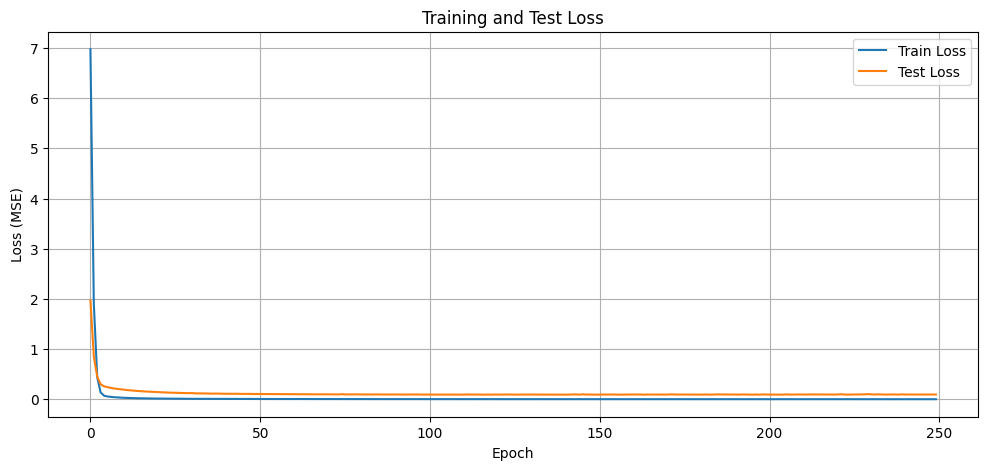

In [32]:
# Plot training and test losses
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

Predicting again! This model has had (by far) the lowest error, so I'm really excited!

In [33]:
nn_model.eval()
with torch.no_grad():

    y_pred_nn = nn_model(X_test_tensor).numpy().flatten()

preds_df = pd.DataFrame({
    "track_name": test_tracks["name"],
    "artist_name": test_tracks["artist_name"],
    "genres": test_tracks["genres"],
    "my_rating": y_test,
    "nn_pred": y_pred_test
})

# order by rating
preds_df = preds_df.sort_values(by = "my_rating", ascending = False)
preds_df

,track_name,artist_name,genres,my_rating,nn_pred
77,Beach Life-In-Death,Car Seat Headrest,"[furry, indie rock, pov: indie]",8.629900,7.265345
888,Siberian Breaks,MGMT,"[alternative rock, indie rock, indietronica, m...",7.770863,7.203257
887,Miroirs: III. Une barque sur l'océan,Maurice Ravel,"[classical, impressionism, neoclassicism, post...",6.640123,5.224488
590,Snow Globes,"Black Country, New Road","[crank wave, indie rock, london indie, uk post...",6.084734,5.596537
373,The Peacocks - Live,Bill Evans Trio,"[bebop, contemporary post-bop, jazz, jazz trio]",5.371002,5.239905
...,...,...,...,...,...
894,Novacaine,BermudaCal,[],1.295887,1.148566
979,I've Always Been,Mac Ayres,[chill r&b],1.290536,1.292130
972,Fair-Weather Friend,Bruno Major,[singer-songwriter pop],1.283787,1.581027
965,Nothing,Bruno Major,[singer-songwriter pop],1.231256,1.695159


Honestly, not bad. I'm kind of seeing the same problems as the XGBoost model, but this models seems more accurate overall, so I'm happy. I think that this might be a general issue for all the models given the simplicity of the models I'm using here, so I'll take what I can get lol.

Anyway, that's really it for the serious models, but just for fun, let's try a nearest-neighbors approach!

In [34]:
from sklearn.neighbors import KNeighborsRegressor

test_losses = []
models = []
for K in range(1, 20):
    
    knn_model = KNeighborsRegressor(n_neighbors = K, weights = 'distance', )
    knn_model.fit(X_train, y_train)
    models.append(knn_model)

    y_pred_test = knn_model.predict(X_test)

    rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
    test_losses.append(rmse_test)

    print(f"Number of neighbors: {K}, RMSE: {rmse_test}")

Number of neighbors: 1, RMSE: 0.5030787869682027
Number of neighbors: 2, RMSE: 0.43732872960624375
Number of neighbors: 3, RMSE: 0.4199217559056235
Number of neighbors: 4, RMSE: 0.3956921776026718
Number of neighbors: 5, RMSE: 0.40426540242971065
Number of neighbors: 6, RMSE: 0.4059384929449842


Number of neighbors: 7, RMSE: 0.41464083441805843
Number of neighbors: 8, RMSE: 0.4266882230377878
Number of neighbors: 9, RMSE: 0.4324894439837706
Number of neighbors: 10, RMSE: 0.4332847966457313
Number of neighbors: 11, RMSE: 0.44566835170833746
Number of neighbors: 12, RMSE: 0.4565199499829414
Number of neighbors: 13, RMSE: 0.4601809681263233
Number of neighbors: 14, RMSE: 0.46474910513006473
Number of neighbors: 15, RMSE: 0.4699564260953002
Number of neighbors: 16, RMSE: 0.4750350656346203
Number of neighbors: 17, RMSE: 0.48151959121393234
Number of neighbors: 18, RMSE: 0.4830770048479614
Number of neighbors: 19, RMSE: 0.4866642496272801


Looks like roughly $K = 5$ is the best value for the number of neighbors. Let's see what kind of predictions we have! Again, not really expecting much here, but kNN was the first ML method I learned, so I wanted to include it in this project because I like it.

In [35]:
best_knn_model = models[np.argmin(test_losses)]
y_pred_test = best_knn_model.predict(X_test)

preds_df = pd.DataFrame({
    "track_name": test_tracks["name"],
    "artist_name": test_tracks["artist_name"],
    "genres": test_tracks["genres"],
    "my_rating": y_test,
    "knn_pred": y_pred_test
})

# order by rating
preds_df = preds_df.sort_values(by = "my_rating", ascending = False)
preds_df

,track_name,artist_name,genres,my_rating,knn_pred
77,Beach Life-In-Death,Car Seat Headrest,"[furry, indie rock, pov: indie]",8.629900,8.143986
888,Siberian Breaks,MGMT,"[alternative rock, indie rock, indietronica, m...",7.770863,8.150679
887,Miroirs: III. Une barque sur l'océan,Maurice Ravel,"[classical, impressionism, neoclassicism, post...",6.640123,5.014023
590,Snow Globes,"Black Country, New Road","[crank wave, indie rock, london indie, uk post...",6.084734,5.031383
373,The Peacocks - Live,Bill Evans Trio,"[bebop, contemporary post-bop, jazz, jazz trio]",5.371002,4.455445
...,...,...,...,...,...
894,Novacaine,BermudaCal,[],1.295887,1.844608
979,I've Always Been,Mac Ayres,[chill r&b],1.290536,1.710380
972,Fair-Weather Friend,Bruno Major,[singer-songwriter pop],1.283787,1.586014
965,Nothing,Bruno Major,[singer-songwriter pop],1.231256,2.054338


Honestly, not bad! This actually makes more sense in retrospect, since the songs I like are (naturally) related to each other, so a new song I haven't heard is (t0 me) probably just about as good as other similar songs I've heard.

Overall, I think the XGBoost and neural network models performed the best, with NN and random forest close behind, and linear regression a bit worse than that. Still, I'm pretty happy with these results, and I'm excited to see what they predict! To save myself listening time, I'm just going to make playlists using the neural network model for now, but I'll definitely come back to this and try with every model because it's been months and my discover weekly has still been bad lol.

# Predictions

Now, I'm just gonna be predicting on the testing space and picking the songs that it rates the best to listen to!

In [36]:
X_test_final = scaled_recs
print(f"Shape of X_test_final: {X_test_final.shape}")
X_test_final

Shape of X_test_final: (16522, 12)


,popularity,explicit,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.520608,0,-0.306324,-0.443245,0.614814,0.737415,-0.726439,-1.155406,-0.462532,-0.614884,-0.274577,-0.866505
1,-0.394316,0,0.626267,0.899243,0.544639,1.048748,-0.673499,-1.127119,-0.462514,-0.744013,0.693390,0.024860
2,-1.453702,0,-0.101821,-2.323886,-0.297450,0.776730,-0.640106,0.955633,0.079945,0.211133,-1.551948,-0.197833
3,-0.298008,1,-0.722385,-0.541617,-1.092757,-1.098488,0.337249,1.640091,-0.462724,-0.785690,1.445293,-0.261336
4,-0.346162,0,1.472756,-1.218648,-1.172288,-0.602694,-0.723996,0.758775,-0.462535,-0.610101,-1.216617,0.846674
...,...,...,...,...,...,...,...,...,...,...,...,...
16517,-0.827701,0,0.202003,-0.611056,0.830014,0.424171,-0.538298,-0.913604,-0.458827,-0.308117,0.961310,1.873669
16518,-0.490624,1,-0.050924,-0.182849,0.984397,-0.424608,-0.685716,0.710318,-0.462665,-0.789789,0.892169,0.780923
16519,-0.490624,0,0.015157,-0.616843,0.937615,0.411420,-0.698747,0.546775,1.725898,-0.335446,0.844635,-1.053480
16520,-0.972163,0,0.564691,-1.068196,0.123595,0.597794,-0.680015,0.495289,-0.451187,-0.355942,-0.317790,0.094344


In [37]:
X_test_final_tensor = torch.tensor(X_test_final.values, dtype = torch.float32)

nn_model.eval()
with torch.no_grad():
    y_pred_final = nn_model(X_test_final_tensor).numpy().flatten()
    
y_pred_final = y_pred_final / y_pred_final.max() * 10

preds_df = pd.DataFrame({
    "id": recs["id"],
    "track_name": recs["name"],
    "artist_name": recs["artist_name"],
    "genres": recs["genres"],
    "pred_rating": y_pred_final
})

# order by rating
preds_df = preds_df.sort_values(by = "pred_rating", ascending = False)
preds_df

,id,track_name,artist_name,genres,pred_rating
594,6OkDQI3XFhWc4Ui18hi66h,How Deep Is The Ocean,Al Cohn,[jazz saxophone],10.000000
4374,4ShVovnLIlObG43vwaCRkJ,Basketball Shoes,"Black Country, New Road","[crank wave, indie rock, london indie, uk post...",8.822583
12040,26ehLobAhGshu4rBTWMLzi,Superpower,Beyoncé,"[pop, r&b]",8.619534
16481,1ouUzHqM94X39bGtVeem77,Kamen,Platypus Crew,[],8.080212
9206,7DTWCc2yloWZDxTz97wHz2,여름: 모호함 속의 너 / 2악장 / 놓아줄 때가 되면 놓아주기 (Concerto),Della Zyr,[korean shoegaze],8.005160
...,...,...,...,...,...
5001,7GfNOvMCTRh2WR1n6gUt0A,VIRGINIA CREEPER,greek,[],0.757292
10067,45ar5ndSjioSD1aNkLleLR,FIREFIGHTER - Instrumental,Muchi,[chill abstract hip hop],0.740935
668,4wkncmPcHyyZ33qfdQHUV2,Swingin' in the Promised Land (11-14-38),Edgar Hayes,"[vintage jazz, vintage swing]",0.714661
9796,7nXEAuHxKZah0ewQILSYtq,jump!,Dyan Dxddy,[phonk brasileiro],0.660940


Excited to listen to these!

# Generating the playlist

In [38]:
# A pred_rating > 6 gives a good amount of songs for me to listen to
add = preds_df[preds_df["pred_rating"] > 6]["id"]

In [39]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

with open ("./personal_details.in") as f:
    CLIENT_ID = f.readline().strip()
    CLIENT_SECRET = f.readline().strip()
    REDIRECT_URL = f.readline().strip()
    SCOPE = f.readline().strip()

sp = spotipy.Spotify(auth_manager = SpotifyOAuth(
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    redirect_uri = REDIRECT_URL,
    scope = SCOPE 
))

# Initialize the playlist
pl = sp.user_playlist_create(
    user = "dooooooonut",
    name = "AI Recommendations Revisited 01",
    public = False,
    collaborative = False,
    description = "Hopefully this is good"
)

# Add the tracks
for id in add:
    sp.user_playlist_add_tracks(
        user = "dooooooonut",
        playlist_id = pl["id"],
        tracks = [id]
    )

# Conclusion

Despite the amount of time I spent on the project as a whole and, especially, the proportion of time I spent on preprocessing (far more than I initially anticipated), I'm happy to say that I was enthusiastic about it the whole time. In fact, the longer I spent, the more rewarded I felt when something worked! There was a certain beauty in the rhythm of advancing one step, only to go back three before finally leaping forward by ten. This sort of dance taught me so many invaluable lessons in patience, something I usually struggle with when coding.

As I navigated through each phase of the project, I encountered so many obstacles that I hadn't anticpated even as late as the morning before. These hurdles ranged from minor file read errors to major conceptual roadblocks with my data. However, each issue presented an opportunity to delve deeper into the intricacies of each tool and method I had used. Indeed,I found myself exploring new realms of knowledge, pushing the boundaries of my understanding, and honing my problem-solving skills doing something I started just because I wanted better music!

Furthermore, this project was born from a personal dissatisfaction with my current situation. Transforming this dissatisfaction into a creative and productive endeavor was a really empowering experience. Not only was I able to fix an issue in my life with skills I had learned myself, but I was able to do it pretty well!

There were moments where I was intensely frusturated often punctuated by huge breakthroughs, but these emotional swings added richness to my experience of this project, making the eventual success that much better.

Thinking about this project more generally, I realized that it's been a significant milestone in my journey as a programmer and a data scientist. The confidence I've gained is immeasurable, and I'm eagerly anticipating the opportunity to revisit this project, armed with new knowledge and ideas, ready to implement the advancements I've envisioned above.

I really believe that this was more than just a technical exercise; it was a transformative experience that has reshaped my perspective on learning and reinforced the idea that I would want to do this with my life. The lessons I've learned from this project extend way beyond the realm of data science; they are life lessons I'm excited to say will guide me in my future endeavors.